A first attempt at reverse engineering the geometry of CLIP embeddings on CIFAR10.

### Load libraries

In [1]:
import copy
import pathlib
import sys

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src.pretrain import linear_probe
from src.utils import runs_to_df

### Load data

In [2]:
d = np.load(
    "/home/gridsan/groups/ccg/data/scaling/clip-embeddings/cifar10_clip.npz"
)

XS_TRAIN, YS_TRAIN = d["xs_train"], d["ys_train"]
XS_TEST, YS_TEST = d["xs_test"], d["ys_test"]
print(XS_TRAIN.shape, XS_TEST.shape)
DS = linear_probe.Dataset(XS_TRAIN, YS_TRAIN, XS_TEST, YS_TEST)

CIFAR_CLS_NAMES = (
    "airplane",
    "car",  # "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


(50000, 768) (10000, 768)


### Compute gaussian proxy of data

In [3]:
DS_G = copy.deepcopy(DS)
for c in range(10):
    mask_train = DS_G.ys_train == c
    mask_test = DS_G.ys_test == c

    xs = np.concatenate([DS_G.xs_train[mask_train], DS_G.xs_test[mask_test]])

    # Fit a gaussian to xs
    mu = np.mean(xs, axis=0)
    sigma = np.cov(xs, rowvar=False)

    # Sample from the gaussian
    n_train = np.sum(mask_train)
    n_test = np.sum(mask_test)
    xs_train_g = np.random.multivariate_normal(mu, sigma, size=n_train)
    xs_test_g = np.random.multivariate_normal(mu, sigma, size=n_test)

    # Replace the original data with the gaussian samples
    DS_G.xs_train[mask_train] = xs_train_g
    DS_G.xs_test[mask_test] = xs_test_g

# Visualize embeddings

In [4]:
def plot_embeddings(xs: np.ndarray, ys: np.ndarray, **plt_kwargs):
    for c in range(10):
        mask = ys == c
        plt.scatter(
            xs[mask, 0],
            xs[mask, 1],
            label=CIFAR_CLS_NAMES[c],
            **plt_kwargs,
        )

    # Show legend with larger and alpha=1 markers
    # Put the legend on the outside top-right of the plot
    leg = plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    for lh in leg.legendHandles:  # type: ignore
        lh.set_alpha(1)
        lh.set_sizes([69])


### TSNE
Abandoned because it takes too long to run
(over 2 minutes to visualize cifar).

In [5]:
# Visualize the embeddings using t-SNE
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, random_state=0)
# x_2d = tsne.fit_transform(DS.xs_train)

# plt.figure(figsize=(10, 10))
# plt.scatter(x_2d[:, 0], x_2d[:, 1], c=DS.ys_train, cmap="tab10")
# # Takes more than 2 minutes to run...

### UMAP

In [6]:
UMAP_SEED = 1

In [7]:
# Compute UMAP embeddings
red = umap.UMAP(random_state=UMAP_SEED)
x_2d: np.ndarray = red.fit_transform(DS.xs_train) # type: ignore

In [8]:
# Compute UMAP embeddings on normalized data
red_norm = umap.UMAP(random_state=UMAP_SEED)
ss = StandardScaler()
xs_train_norm = ss.fit_transform(DS.xs_train)
x_2d_norm: np.ndarray = red_norm.fit_transform(xs_train_norm) # type: ignore

In [9]:
# Compute UMAP embeddings of test data as well
x_2d_test: np.ndarray = red.transform(DS.xs_test) # type: ignore
x_2d_test_norm: np.ndarray = red_norm.transform(ss.transform(DS.xs_test)) # type: ignore

In [10]:
# Compute UMAP embeddings of gaussian test data
x_2d_test_g: np.ndarray = red.transform(DS_G.xs_test) # type: ignore
x_2d_test_g_norm: np.ndarray = red_norm.transform(ss.transform(DS_G.xs_test)) # type: ignore

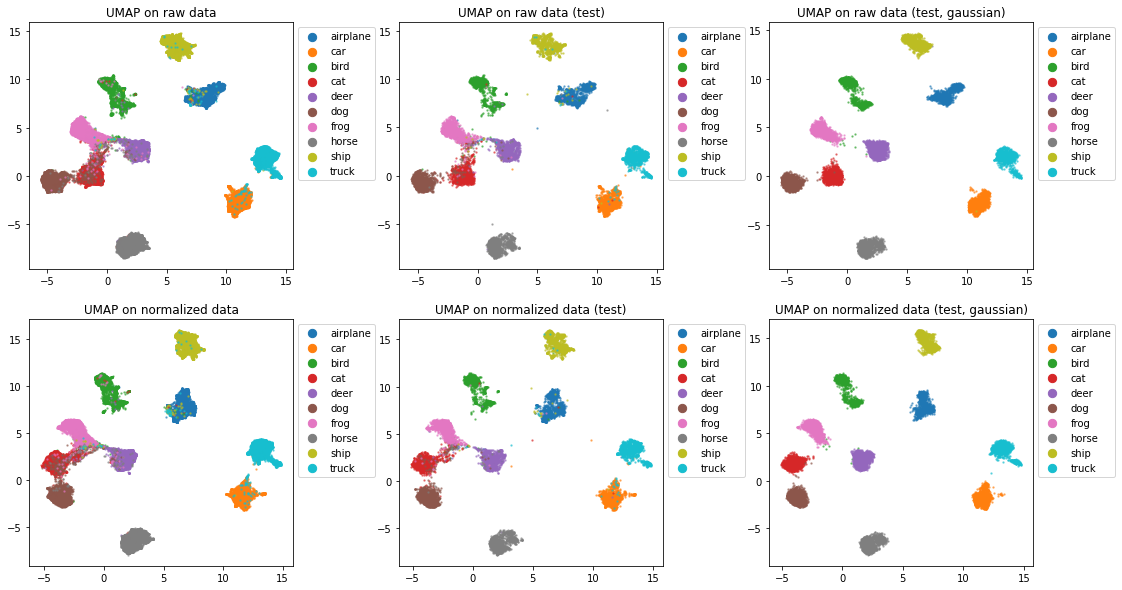

In [11]:
plt.figure(figsize=(18, 10))
# Increase space between plots
plt.subplots_adjust(wspace=0.4)

s = 2
alpha = 0.5

plt.subplot(2, 3, 1)
plot_embeddings(x_2d, DS.ys_train, s=s, alpha=alpha)
plt.title("UMAP on raw data")

plt.subplot(2, 3, 2)
plot_embeddings(x_2d_test, DS.ys_test, s=s, alpha=alpha)
plt.title("UMAP on raw data (test)")

plt.subplot(2, 3, 3)
plot_embeddings(x_2d_test_g, DS_G.ys_test, s=s, alpha=alpha)
plt.title("UMAP on raw data (test, gaussian)")

plt.subplot(2, 3, 4)
plot_embeddings(x_2d_norm, DS.ys_train, s=s, alpha=alpha)
plt.title("UMAP on normalized data")

plt.subplot(2, 3, 5)
plot_embeddings(x_2d_test_norm, DS.ys_test, s=s, alpha=alpha)
plt.title("UMAP on normalized data (test)")

plt.subplot(2, 3, 6)
plot_embeddings(x_2d_test_g_norm, DS_G.ys_test, s=s, alpha=alpha)
plt.title("UMAP on normalized data (test, gaussian)");